In [1]:
%matplotlib inline
import os,sys
import matplotlib
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import sfdmap
import extinction
from astropy import units as u
import math
import pylatex

# pyqsofit
from scipy import interpolate

# for SDSS SQL queries
#import mechanize
#from io import BytesIO

import glob,timeit

#sys.path.append('/Users/runnojc1/Software/py/pyspeckit')
import pyspeckit
from pyspeckit.spectrum.models.inherited_gaussfitter import gaussian
from pyspeckit.specwarnings import PyspeckitWarning
from astropy.table import Table

import warnings
from astropy.units import UnitsWarning

In [2]:
def kms_to_ang(dv,w0):
    """
    Convert a width in km/s to A.
    """
    c = 2.99792458e5 # km/s
    dlam = (dv/c)*w0
    return dlam

In [3]:
def gaussian(xarr,amplitude,cent,fwhm,normalized=False,return_components=False,return_hyperfine_components=False):
    """
    Returns a 1-dimensional gaussian of form
    A*np.exp(-(x-dx)**2/(2*w**2))

    Area is sqrt(2*pi*sigma^2)*amplitude - i.e., this is NOT a normalized
    gaussian, unless normalized=True in which case A = Area
    
    Parameters
    ----------
    xarr : np.ndarray
        array of x values
    amplitude : float
        Amplitude of the Gaussian, i.e. its peak value, unless
        normalized=True then A is the area of the gaussian
    cent : float
        Center or "shift" of the gaussian same units as xarr
    fwhm : float
        Full width at half maximum of the Gaussian in km/s
    return_components : bool
        dummy variable; return_components does nothing but is required by all
        fitters
    return_hyperfine_components : bool
        dummy variable; does nothing but is required by all
        fitters
    normalized : bool
        Return a normalized Gaussian?
    """ 
    fwhm = kms_to_ang(fwhm,cent)
    if fwhm == 0:
        return np.nan
    elif fwhm < 0:
        warnings.warn("Negative width in Gaussian: {0}.".format(fwhm),
                      PyspeckitWarning)

    width = fwhm/np.sqrt(8*np.log(2))
    xarr = np.array(xarr) # make sure xarr is no longer a spectroscopic axis
    model = amplitude*np.exp(-(xarr-cent)**2/(2.0*width**2))
    if normalized:
        return model / (np.sqrt(2*np.pi) * width**2)
    else:
        return model

In [4]:
def powerlaw(x, scale, power):
    """
    Defines a power law

    Returns
    -------
    scale * x**power
    """
    return scale*(x/1000.)**-power

In [5]:
def template_fitter(wave,templates,scale_factor,index,shift):
    '''
    given a series of templates (like stellar models by age or Fe II templates by convolution width),
    returns a spectrum interpolated between template spectra and scaled.
    Spectrum is also interpolated onto the wavelength vector of the observed data.
    
    params:
        wave - wavelength vector of observed data
        templates - 2D numpy array of shape (numpoints,num_templates+1), where 1st column is wavelength, subsequent columns are templates
        index - selected index within templates [0-num_templates]. Float, will interpolate between templates when index!=int
        scale_factor - multiplicative scale factor for spectrum
    '''
    num_templates=templates.shape[1]-1
    numpoints=templates.shape[0]
    
    if shift>=0:
        wave_temp=templates[:,0]*(1+shift)
    else:
        wave_temp=templates[:,0]/(1+shift)
    flux_temp=templates[:,1:]
    
    # Perform interpolation between templates
    if index==num_templates-1:
        spectrum=templates[:,-1]
    else:
        lower_idx=int(math.floor(index)+1) #+1 because 0th index is wavelength column
        lower_spectrum=templates[:,lower_idx] # this means lower in index, not necessarily in flux
        
        upper_idx=lower_idx+1
        upper_spectrum=templates[:,upper_idx]
        
        weight=(index+1)-lower_idx #1=choose upper spectrum value, 0=choose lower spectrum value, 0.5=choose midpoint
        
        distances=upper_spectrum-lower_spectrum # array of distances between selected spectra
        
        spectrum=lower_spectrum+(weight*distances)
        
    # Perform scaling
    scaled_spectrum=spectrum*scale_factor
    
    # interpolate spectrum onto wavelength vector of data
    final_spectrum=np.interp(wave,wave_temp,scaled_spectrum)

    return final_spectrum

# Plotting velocity

In [6]:
file_path = '/home/serat/Downloads/AGN/output/calcos/epoch1/lf0a01b0q_1_x1d.fits'


with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UnitsWarning, append=True)
        w, f, ferr, dq = Table.read(
            file_path)[0]['WAVELENGTH', 'FLUX', 'ERROR', 'DQ']
        
dq_mask = np.where(dq == 0) # filter to good quality data
w, f, ferr = w[dq_mask], f[dq_mask], ferr[dq_mask]


t = Table([w, f, ferr], names=('WAVELENGTH', 'FLUX', 'ERROR'))
t['FLUX'] = t['FLUX']/1e-17

t.sort('WAVELENGTH')



z = 0.081


bin_width = 1

bins = np.arange(min(t["WAVELENGTH"]), max(t["WAVELENGTH"]) + bin_width, bin_width)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

indices = np.digitize(t["WAVELENGTH"], bins)

binned_wl = []
binned_flux = []
binned_flux_err = []


for i in range(1, len(bins)):
    in_bin = indices == i
    if np.any(in_bin):
        binned_wl.append(np.mean(t["WAVELENGTH"][in_bin]))
        binned_flux.append(np.mean(t["FLUX"][in_bin]))
        binned_flux_err.append(np.mean(t["ERROR"][in_bin]))
    else:
        pass

binned_wl = np.array(binned_wl)
flux_lyalpha = np.array(binned_flux)
binned_flux_err = np.array(binned_flux_err)

rest_wavelength = 1216.25*(1+z)

c = 299792.458

vel_lyalpha = c * (binned_wl - rest_wavelength) / rest_wavelength




pl = powerlaw(binned_wl, 26.56421824 , 0.02492611247)


flux_lyalpha = flux_lyalpha - pl



In [7]:
file_path = 'ascii/J14301603+2303445_2023-01-06_COS.dat'

t = Table.read(file_path, format='ascii', delimiter='\s', header_start=3, data_start=5)

column_names = ['Wavelength', 'F_lambda', 'e_F_lambda']

original_colnames = t.colnames

for original, new in zip(original_colnames, column_names):
    t.rename_column(original, new)
    
t.sort('Wavelength')


z = 0.081


bin_width = 1

bins = np.arange(min(t["Wavelength"]), max(t["Wavelength"]) + bin_width, bin_width)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

indices = np.digitize(t["Wavelength"], bins)

print(indices)

binned_wl = []
binned_flux = []
binned_flux_err = []


for i in range(1, len(bins)):
    in_bin = indices == i
    if np.any(in_bin):
        binned_wl.append(np.mean(t["Wavelength"][in_bin]))
        binned_flux.append(np.mean(t["F_lambda"][in_bin]))
        binned_flux_err.append(np.mean(t["e_F_lambda"][in_bin]))
    else:
        pass

binned_wl = np.array(binned_wl)
binned_flux = np.array(binned_flux)
binned_flux_err = np.array(binned_flux_err)


binned_wl = np.array(binned_wl)
flux_civ = np.array(binned_flux)
binned_flux_err = np.array(binned_flux_err)

rest_wavelength = 1546.15

c = 299792.458

vel_civ = c * (binned_wl - rest_wavelength) / rest_wavelength


pl = powerlaw(binned_wl, 26.56421824 , 0.02492611247)


flux_civ = flux_civ - pl


[   1    1    1 ... 1210 1210 1210]


## Halpha

In [8]:
SII1_F0 = 11.1721073
SII1_CENT0 = 6716.04314
SII1_FWHM0 = 393.5954679
SII2_F0 = 8.335673742
SII2_CENT0 = 6730.906927
SII2_FWHM0 = 393.5954679
NII1_F0 = 10.63741401
NII1_CENT0 = 6548.323235
NII1_FWHM0 = 393.5954679
NII2_F0 = 31.52318712
NII2_CENT0 = 6582.888789
NII2_FWHM0 = 393.5954679 
HALPHA1_F0 = 20.63047916
HALPHA1_CENT0 = 6562.187441
HALPHA1_FWHM0 = 393.5954679

OI1_F0 = 7.998443445  
OI1_CENT0 = 6300.416844  
OI1_FWHM0 = 393.5954679  
OI2_F0 = 2.666147815  
OI2_CENT0 = 6367.798683  
OI2_FWHM0 = 393.5954679 

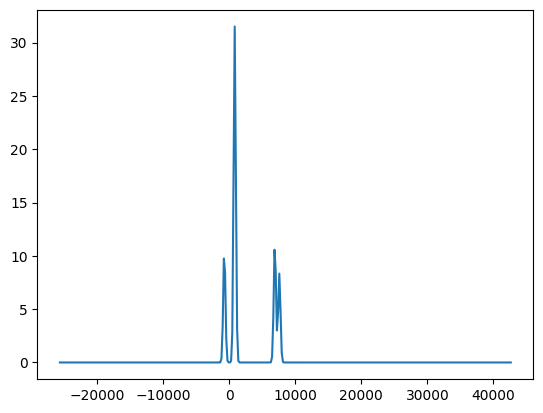

In [9]:
file_name = 'bundle_20230529_standards/spectrum_20230112_0000010_exp01_red.fits'
hdul = fits.open(file_name)
data = hdul[0].data
hdr = hdul[0].header

z = 0.081

wl = data[0]
flux = data[1] * (10**16)
err = data[2]


wl = wl / (1 + z)


mask0 = np.where((wl > 6000) & (wl < 7500))
wl_o = wl[mask0]
flux_o = flux[mask0]
err_o = err[mask0]


mask1 = np.where((wl_o < 6015) | (wl_o > 6170))
wl = wl_o[mask1]
flux = flux_o[mask1]
err = err_o[mask1]

mask2 = np.where((wl < 6340) | (wl > 6445))
wl = wl[mask2]
flux = flux[mask2]
err = err[mask2]

mask3 = np.where((wl < 6455) | (wl > 6800))
wl = wl[mask3]
flux = flux[mask3]
err = err[mask3]

mask4 = np.where((wl < 7000) | (wl > 7130))
wl = wl[mask4]
flux = flux[mask4]
err = err[mask4]


coefficients = np.polyfit(wl, flux, 3)
polynomial = np.poly1d(coefficients)
fitted_continuum = polynomial(wl_o)

degree = 3

coefficients = np.polyfit(wl, flux, degree)
polynomial_continuum = np.poly1d(coefficients)(wl_o)
standard_flux = flux_o / polynomial_continuum
standard_wl = wl_o

file_path = 'HET/combined_spectrum_20230113_0000022_exp01.fits'

t = Table.read(file_path)
t.sort('Wavelength')

z = 0.081
wl = t['Wavelength']/(1+z)
flux = t['F_lambda'] * (10**17)
err = t['e_F_lambda'] * (10**17)

flux_lim = np.where(flux>0)[0]
source_wl=wl[flux_lim]
source_flux=flux[flux_lim]
source_err=err[flux_lim]

wl_lim = np.where((source_wl>6000)&(source_wl<7500))
source_wl=source_wl[wl_lim]
source_flux=source_flux[wl_lim]
source_err=source_err[wl_lim]

shift = 0
scale = 1.18

tmp = standard_flux

standard_wl = standard_wl + shift
tmp = (1-(1-tmp)**scale)
inf = np.where(np.isfinite(tmp) == False)[0]

standard_flux[inf] = 1
standard_flux = (1-(1-standard_flux)**scale)

mask1 = np.where(standard_wl < 6340)[0]
mask2 = np.where((standard_wl > 6445) & (standard_wl < 6455))[0]
mask3 = np.where((standard_wl > 6800) & (standard_wl < 7010))[0]
mask4 = np.where(standard_wl > 7130)[0]

standard_flux[mask1] = 1
standard_flux[mask2] = 1
standard_flux[mask3] = 1
standard_flux[mask4] = 1



bin_size = 4
bins = np.arange(start=min(np.min(source_wl), np.min(standard_wl)), stop=max(np.max(source_wl), np.max(standard_wl)) + bin_size, step=bin_size)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
wavelength = bin_centers


indices1 = np.digitize(source_wl, bins) - 1
indices2 = np.digitize(standard_wl, bins) - 1
source_flux = np.array([np.mean(source_flux[indices1 == i]) for i in range(len(bin_centers))])
standard_flux = np.array([np.mean(standard_flux[indices2 == i]) for i in range(len(bin_centers))])
binned_err = np.array([np.mean(source_err[indices1 == i]) for i in range(len(bin_centers))])


flux_halpha = source_flux / standard_flux
corrected_wl = bin_centers

rest_wavelength = 6564.93

c = 299792.458

vel_halpha = c * (corrected_wl - rest_wavelength) / rest_wavelength


pl = powerlaw(corrected_wl, 6.726822875, -0.9262954893 )

x = np.array(corrected_wl)

sii1 = gaussian(x,SII1_F0,SII1_CENT0,SII1_FWHM0,normalized=False)
sii2 = gaussian(x,SII2_F0,SII2_CENT0,SII2_FWHM0,normalized=False)

nii1 = gaussian(x,NII1_F0,NII1_CENT0,NII1_FWHM0,normalized=False)
nii2 = gaussian(x,NII2_F0,NII2_CENT0,NII2_FWHM0,normalized=False)

oi1 = gaussian(x,OI1_F0,OI1_CENT0,OI1_FWHM0,normalized=False)
oi2 = gaussian(x,OI2_F0,OI2_CENT0,OI2_FWHM0,normalized=False)

halpha = gaussian(x,HALPHA1_F0,HALPHA1_CENT0,HALPHA1_FWHM0,normalized=False)


flux_halpha = flux_halpha - (pl + sii1 + sii2 + nii1 + nii2 + halpha + oi1 + oi2)

plt.plot(vel_halpha, nii1+nii2+sii1+sii2)
plt.show()

## Hbeta

In [58]:
O3L1_F0 = 33.5646128  
O3L1_CENT0 = 5007.099988  
O3L1_FWHM0 = 352.5029935  
O3L2_F0 = 40.04323893  
O3L2_CENT0 = 5006.516025  
O3L2_FWHM0 = 660.4243646  
O3S1_F0 = 11.18820427  
O3S1_CENT0 = 4959.166892  
O3S1_FWHM0 = 352.5029935  
O3S2_F0 = 13.34774631  
O3S2_CENT0 = 4958.588519  
O3S2_FWHM0 = 660.4243646  
HBN1_F0 = 4.443330544  
HBN1_CENT0 = 4861.615083  
HBN1_FWHM0 = 352.5029935  
HBN2_F0 = 5.300980163  
HBN2_CENT0 = 4861.048087  
HBN2_FWHM0 = 660.4243646

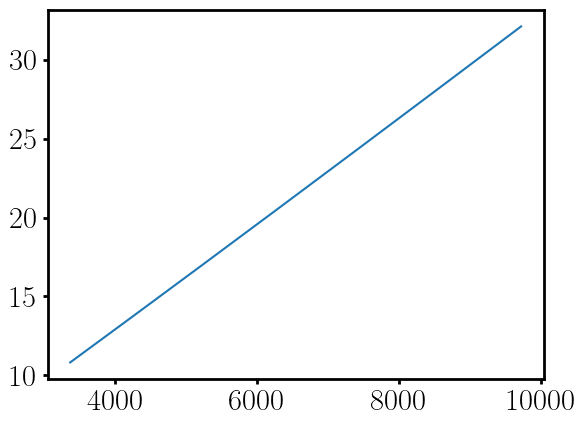

In [59]:
path_dust = '/home/serat/Downloads/sfddata-master/'
path_data = 'HET/'

z   = 0.081
ra  = 217.5668392      
dec =23.06236944

filename = "combined_spectrum_20230113_0000021_exp01.fits"

t = Table.read(path_data+filename)
t.sort('Wavelength')
lam = np.array(t["Wavelength"])
flux_red = np.array(t["F_lambda"] * 10**17)
err  = np.array(1./np.sqrt(t['e_F_lambda']))
err[np.where(err==np.inf)] = np.max(err[np.where(err!=np.inf)])


lam = np.nan_to_num(lam)
flux_red = np.nan_to_num(flux_red)
err = np.nan_to_num(err)

# deredden the spectrum
m   = sfdmap.SFDMap(path_dust)
ebv = m.ebv(ra, dec)
Av  = 3.1*ebv
zero_flux  = np.where(flux_red == 0, True, False)
flux_red[zero_flux] = 1e-10
flux = extinction.remove(extinction.fitzpatrick99(lam.astype('double'),Av, 3.1),flux_red)
err_unred  = err*flux/flux_red
flux[zero_flux] = 0
err_unred[zero_flux] = 0

lam = lam/(1+z)

bin_width = 3

bins = np.arange(min(lam), max(lam) + bin_width, bin_width)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

indices = np.digitize(lam, bins)


binned_wl = []
binned_flux = []

for i in range(1, len(bins)):
    in_bin = indices == i
    if np.any(in_bin):
        binned_wl.append(np.mean(lam[in_bin]))
        binned_flux.append(np.mean(flux[in_bin]))
    else:
        pass

binned_wl = np.array(binned_wl)
flux_hbeta = np.array(binned_flux)

rest_wavelength = 4861.333

c = 299792.458

vel_hbeta = c * (binned_wl - rest_wavelength) / rest_wavelength



pl = powerlaw(binned_wl, 3.113853609, -1.026120731)

x = binned_wl

o3l1 = gaussian(x,O3L1_F0,O3L1_CENT0,O3L1_FWHM0,normalized=False)
o3l2 = gaussian(x,O3L2_F0,O3L2_CENT0,O3L2_FWHM0,normalized=False)

o3s1 = gaussian(x,O3S1_F0,O3S1_CENT0,O3S1_FWHM0,normalized=False)
o3s2 = gaussian(x,O3S2_F0,O3S2_CENT0,O3S2_FWHM0,normalized=False)

hbn1 = gaussian(x,HBN1_F0,HBN1_CENT0,HBN1_FWHM0,normalized=False)
hbn2 = gaussian(x,HBN2_F0,HBN2_CENT0,HBN2_FWHM0,normalized=False)


stellar_template_path='/home/serat/Downloads/PyQSOfit_MILES_templates.dat'
stellar_template = np.genfromtxt(stellar_template_path,skip_header=5)
sb = template_fitter(binned_wl,stellar_template,18.1912,6.95649,0)


flux_hbeta = flux_hbeta - (pl + sb + o3l1 + o3l2 + o3s1 + o3s2 + hbn1 + hbn2)




plt.plot(binned_wl, pl)
plt.show()

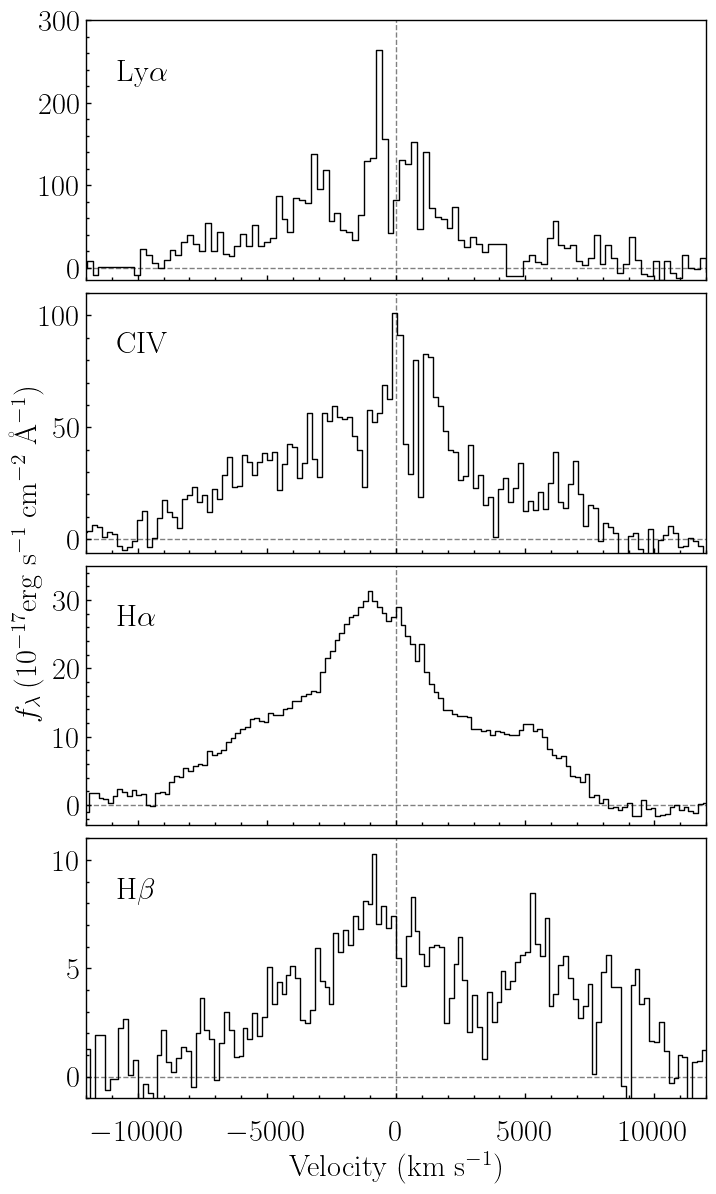

In [60]:
plt.rc('text', usetex=True)
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 22,
    'axes.linewidth': 1,
    'xtick.major.width': 2,
    'ytick.major.width': 2,
    'xtick.minor.width': 2,
    'ytick.minor.width': 2
})

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(8, 14), sharex=True)
plt.subplots_adjust(#left=0.2,
                    #bottom=0.09,
                    #right=0.8,
                    #top=0.98,
                    #wspace=0.2,
                    hspace=0.05)

# Define the common line width
line_width = 1.0

# Function to set the border width of the axes
def set_border_width(ax, width):
    for spine in ax.spines.values():
        spine.set_linewidth(width)

# Set up x-axis ticks
major_ticks = np.arange(-10000, 10001, 5000)
minor_ticks = np.arange(-10000, 10001, 1000)

# Plot Lyalpha
ax1.axvline(x=0, color='grey', linestyle='--', linewidth=line_width, zorder=1)
ax1.axhline(y=0, color='grey', linestyle='--', linewidth=line_width, zorder=1)  
ax1.plot(vel_lyalpha, flux_lyalpha, color="black", drawstyle='steps-mid', linewidth=line_width, zorder=1)
ax1.set_xlim(-15000, 15000)
ax1.set_ylim(-15, 300)
ax1.text(0.05, 0.85, r'Ly$\alpha$', transform=ax1.transAxes, verticalalignment='top', fontsize=22, fontweight='bold', fontfamily='serif')
set_border_width(ax1, line_width)
ax1.set_xticks(major_ticks)
ax1.set_xticks(minor_ticks, minor=True)

# Plot CIV
ax2.axvline(x=0, color='grey', linestyle='--', linewidth=line_width, zorder=1)
ax2.axhline(y=0, color='grey', linestyle='--', linewidth=line_width, zorder=1)  
ax2.plot(vel_civ, flux_civ, color="black", drawstyle='steps-mid', linewidth=line_width, zorder=1)
ax2.set_xlim(-15000, 15000)
ax2.set_ylim(-6, 110)
ax2.text(0.05, 0.85, r'CIV', transform=ax2.transAxes, verticalalignment='top', fontsize=22, fontweight='bold', fontfamily='serif')
set_border_width(ax2, line_width)
ax2.set_xticks(major_ticks)
ax2.set_xticks(minor_ticks, minor=True)

# Plot Halpha
ax3.axvline(x=0, color='grey', linestyle='--', linewidth=line_width, zorder=1)
ax3.axhline(y=0, color='grey', linestyle='--', linewidth=line_width, zorder=1)  
ax3.plot(vel_halpha, flux_halpha, color="black", drawstyle='steps-mid', linewidth=line_width, zorder=1)
ax3.set_xlim(-15000, 15000)
ax3.set_ylim(-3, 35)
ax3.text(0.05, 0.85, r'H$\alpha$', transform=ax3.transAxes, verticalalignment='top', fontsize=22, fontweight='bold', fontfamily='serif')
set_border_width(ax3, line_width)
ax3.set_xticks(major_ticks)
ax3.set_xticks(minor_ticks, minor=True)

# Plot Hbeta
ax4.axvline(x=0, color='grey', linestyle='--', linewidth=line_width, zorder=1)
ax4.axhline(y=0, color='grey', linestyle='--', linewidth=line_width, zorder=1)  
ax4.plot(vel_hbeta, flux_hbeta, color="black", drawstyle='steps-mid', linewidth=line_width, zorder=1)
ax4.set_xlim(-12000, 12000)
ax4.set_ylim(-1, 11)
ax4.text(0.05, 0.85, r'H$\beta$', transform=ax4.transAxes, verticalalignment='top', fontsize=22, fontweight='bold', fontfamily='serif')
set_border_width(ax4, line_width)
ax4.set_xticks(major_ticks)
ax4.set_xticks(minor_ticks, minor=True)

# Common y-axis label
fig.text(0.03, 0.5, r'$f_{\lambda} \:(10^{-17} \mathrm{erg\ s^{-1}\ cm^{-2}\ \AA^{-1}})$', va='center', rotation='vertical')

# Add minor ticks and set tick parameters
for ax in [ax1, ax2, ax3, ax4]:
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', direction='in', width=line_width)
    ax.tick_params(axis='x', which='major', pad=15)
    ax.tick_params(axis='x', which='minor', pad=10)

ax4.set_xlabel(r"Velocity (km s$^{-1}$)")

#plt.tight_layout()#rect=[0.05, 0, 1, 1])
plt.savefig("paper_figures/decomposed_spectra.pdf", format='pdf', bbox_inches='tight')
plt.show()


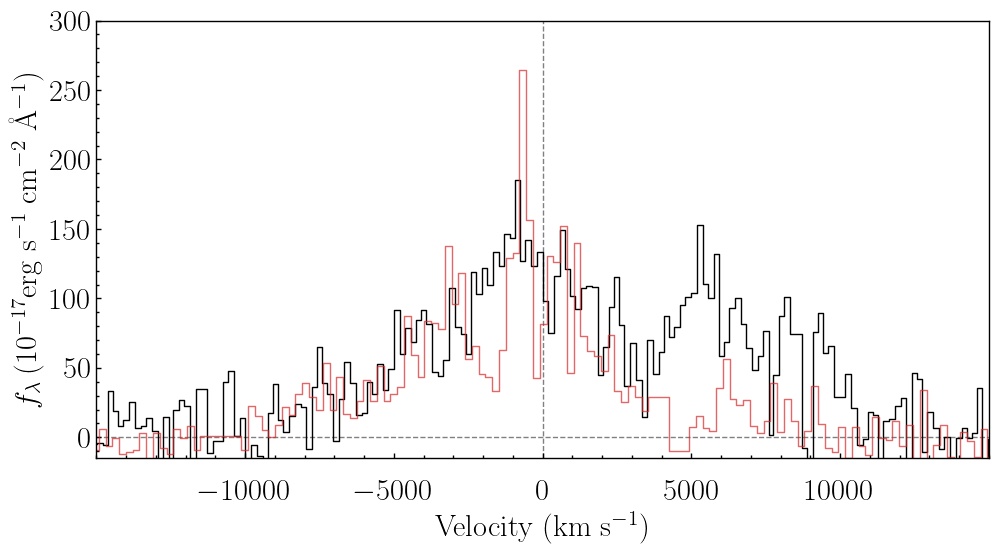

In [75]:
plt.rc('text', usetex=True)
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 22,
    'axes.linewidth': 2,
    'xtick.major.width': 2,
    'ytick.major.width': 2,
    'xtick.minor.width': 2,
    'ytick.minor.width': 2
})

fig, ax = plt.subplots(figsize=(11, 6))

line_width = 1.0

def set_border_width(ax, width):
    for spine in ax.spines.values():
        spine.set_linewidth(width)

major_ticks = np.arange(-10000, 10001, 5000)
minor_ticks = np.arange(-10000, 10001, 1000)

ax.axvline(x=0, color='grey', linestyle='--', linewidth=line_width, zorder=1)
ax.axhline(y=0, color='grey', linestyle='--', linewidth=line_width, zorder=1)

ax.plot(vel_hbeta, flux_hbeta*18, color="black", drawstyle='steps-mid', linewidth=line_width, zorder=2, label=r'H$\beta$', alpha=1)
ax.plot(vel_lyalpha, flux_lyalpha, color="#D62728", drawstyle='steps-mid', linewidth=line_width, zorder=2, label=r'Ly$\alpha$', alpha=0.7)

ax.set_xlim(-15000, 15000)
ax.set_ylim(-15, 300)

set_border_width(ax, line_width)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

ax.set_xlabel("Velocity (km s$^{-1}$)")
ax.set_ylabel(r'$f_{\lambda} \:(10^{-17} \mathrm{erg\ s^{-1}\ cm^{-2}\ \AA^{-1}})$')

ax.minorticks_on()
ax.tick_params(axis='both', which='both', direction='in', width=line_width)
ax.tick_params(axis='x', which='major', pad=15)
ax.tick_params(axis='x', which='minor', pad=10)

#ax.legend()

plt.tight_layout(rect=[0.05, 0, 1, 1])
plt.savefig("paper_figures/overlap_spectra.pdf", format='pdf', bbox_inches='tight')
plt.show()

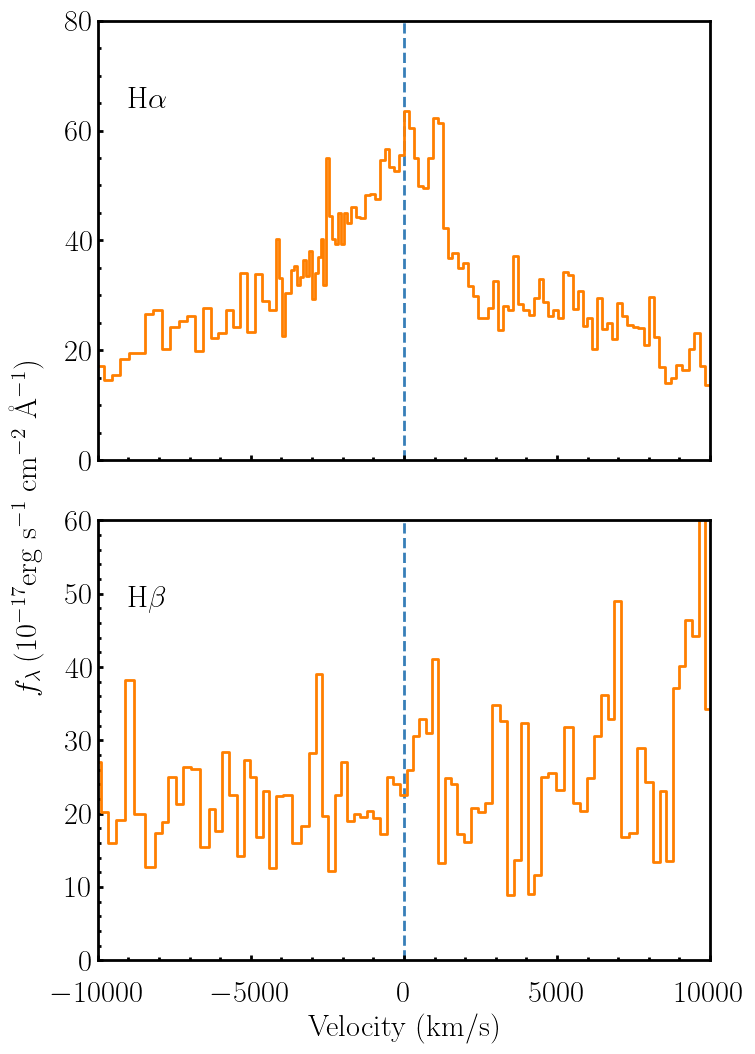

In [24]:

# Define constants
c = 299792.458
lambda_0_halpha = 6562
lambda_0_hbeta = 4861.333

def wavelength_to_velocity(wavelength, lambda_0):
    return c * (wavelength - lambda_0) / lambda_0

def bin_data(velocity, flux, bin_size):
    num_bins = len(velocity) // bin_size
    binned_velocity = np.zeros(num_bins)
    binned_flux = np.zeros(num_bins)
    
    for i in range(num_bins):
        start = i * bin_size
        end = start + bin_size
        binned_velocity[i] = np.mean(velocity[start:end])
        binned_flux[i] = np.mean(flux[start:end])
    
    return binned_velocity, binned_flux

# Read the data from the FITS file
t = Table.read('/home/serat/Downloads/AGN/data/combined_regions.fits')

# Convert wavelength to velocity for H-alpha
velocity_halpha = wavelength_to_velocity(t['wavelength'], lambda_0_halpha)
flux_halpha = t['flux']
binned_velocity_halpha, binned_flux_halpha = bin_data(velocity_halpha, flux_halpha, bin_size=20)

# Convert wavelength to velocity for H-beta
velocity_hbeta = wavelength_to_velocity(t['wavelength'], lambda_0_hbeta)
flux_hbeta = t['flux']
binned_velocity_hbeta, binned_flux_hbeta = bin_data(velocity_hbeta, flux_hbeta, bin_size=4)

# Plot the binned velocity profiles
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 11), sharex=True)

# Define the common line width
line_width = 2.0

# Function to set the border width of the axes
def set_border_width(ax, width):
    for spine in ax.spines.values():
        spine.set_linewidth(width)

# Set up x-axis ticks
major_ticks = np.arange(-10000, 10001, 5000)
minor_ticks = np.arange(-10000, 10001, 1000)

# Plot H-alpha
ax1.axvline(x=0, color='#377eb8', linestyle='--', linewidth=line_width, zorder=1)
ax1.plot(binned_velocity_halpha, binned_flux_halpha, color="#ff7f00", drawstyle='steps-mid', linewidth=line_width, zorder=2)
ax1.set_xlim(-10000, 10000)
ax1.set_ylim(0, 80)
ax1.text(0.05, 0.85, r'H$\alpha$', transform=ax1.transAxes, verticalalignment='top')
set_border_width(ax1, line_width)
ax1.set_xticks(major_ticks)
ax1.set_xticks(minor_ticks, minor=True)

# Plot H-beta
ax2.axvline(x=0, color='#377eb8', linestyle='--', linewidth=line_width, zorder=1)
ax2.plot(binned_velocity_hbeta, binned_flux_hbeta, color="#ff7f00", drawstyle='steps-mid', linewidth=line_width, zorder=2)
ax2.set_xlim(-10000, 10000)
ax2.set_ylim(0, 60)
ax2.text(0.05, 0.85, r'H$\beta$', transform=ax2.transAxes, verticalalignment='top')
set_border_width(ax2, line_width)
ax2.set_xticks(major_ticks)
ax2.set_xticks(minor_ticks, minor=True)

# Common y-axis label
fig.text(0.04, 0.5, r'$f_{\lambda} \:(10^{-17} \mathrm{erg\ s^{-1}\ cm^{-2}\ \AA^{-1}})$', va='center', rotation='vertical')

# Add minor ticks and set tick parameters
for ax in [ax1, ax2]:
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', direction='in', width=line_width)
    ax.tick_params(axis='x', which='major', pad=15)
    ax.tick_params(axis='x', which='minor', pad=10)

ax2.set_xlabel("Velocity (km/s)")

plt.tight_layout(rect=[0.05, 0, 1, 1])
#plt.savefig("decomposed_spectra.pdf", format='pdf', bbox_inches='tight')
plt.show()

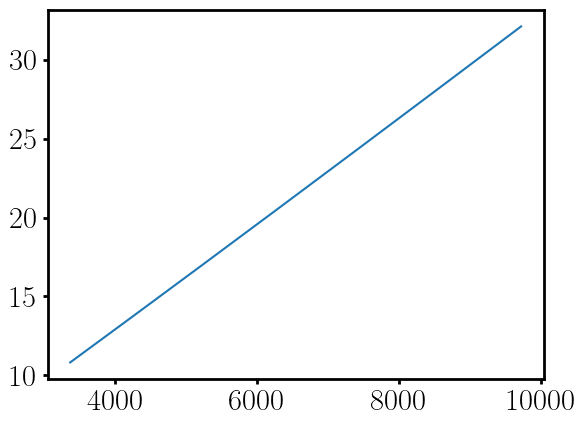

In [25]:
path_dust = '/home/serat/Downloads/sfddata-master/'
path_data = 'HET/'

z   = 0.081
ra  = 217.5668392      
dec =23.06236944

filename = "combined_spectrum_20230113_0000021_exp01.fits"

t = Table.read(path_data+filename)
t.sort('Wavelength')
lam = np.array(t["Wavelength"])
flux_red = np.array(t["F_lambda"] * 10**17)
err  = np.array(1./np.sqrt(t['e_F_lambda']))
err[np.where(err==np.inf)] = np.max(err[np.where(err!=np.inf)])


lam = np.nan_to_num(lam)
flux_red = np.nan_to_num(flux_red)
err = np.nan_to_num(err)

# deredden the spectrum
m   = sfdmap.SFDMap(path_dust)
ebv = m.ebv(ra, dec)
Av  = 3.1*ebv
zero_flux  = np.where(flux_red == 0, True, False)
flux_red[zero_flux] = 1e-10
flux = extinction.remove(extinction.fitzpatrick99(lam.astype('double'),Av, 3.1),flux_red)
err_unred  = err*flux/flux_red
flux[zero_flux] = 0
err_unred[zero_flux] = 0

lam = lam/(1+z)

bin_width = 3

bins = np.arange(min(lam), max(lam) + bin_width, bin_width)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

indices = np.digitize(lam, bins)


binned_wl = []
binned_flux = []

for i in range(1, len(bins)):
    in_bin = indices == i
    if np.any(in_bin):
        binned_wl.append(np.mean(lam[in_bin]))
        binned_flux.append(np.mean(flux[in_bin]))
    else:
        pass

binned_wl = np.array(binned_wl)
flux_hbeta = np.array(binned_flux)

rest_wavelength = 4861.333

c = 299792.458

vel_hbeta = c * (binned_wl - rest_wavelength) / rest_wavelength



pl = powerlaw(binned_wl, 3.113853609, -1.026120731)

x = binned_wl

o3l1 = gaussian(x,O3L1_F0,O3L1_CENT0,O3L1_FWHM0,normalized=False)
o3l2 = gaussian(x,O3L2_F0,O3L2_CENT0,O3L2_FWHM0,normalized=False)

o3s1 = gaussian(x,O3S1_F0,O3S1_CENT0,O3S1_FWHM0,normalized=False)
o3s2 = gaussian(x,O3S2_F0,O3S2_CENT0,O3S2_FWHM0,normalized=False)

hbn1 = gaussian(x,HBN1_F0,HBN1_CENT0,HBN1_FWHM0,normalized=False)
hbn2 = gaussian(x,HBN2_F0,HBN2_CENT0,HBN2_FWHM0,normalized=False)


stellar_template_path='/home/serat/Downloads/PyQSOfit_MILES_templates.dat'
stellar_template = np.genfromtxt(stellar_template_path,skip_header=5)
sb = template_fitter(binned_wl,stellar_template,18.1912,6.95649,0)


flux_hbeta = flux_hbeta




plt.plot(binned_wl, pl)
plt.show()

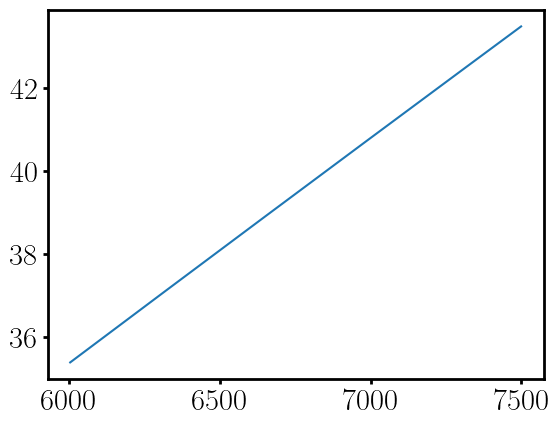

In [26]:
file_name = 'bundle_20230529_standards/spectrum_20230112_0000010_exp01_red.fits'
hdul = fits.open(file_name)
data = hdul[0].data
hdr = hdul[0].header

z = 0.081

wl = data[0]
flux = data[1] * (10**16)
err = data[2]


wl = wl / (1 + z)


mask0 = np.where((wl > 6000) & (wl < 7500))
wl_o = wl[mask0]
flux_o = flux[mask0]
err_o = err[mask0]


mask1 = np.where((wl_o < 6015) | (wl_o > 6170))
wl = wl_o[mask1]
flux = flux_o[mask1]
err = err_o[mask1]

mask2 = np.where((wl < 6340) | (wl > 6445))
wl = wl[mask2]
flux = flux[mask2]
err = err[mask2]

mask3 = np.where((wl < 6455) | (wl > 6800))
wl = wl[mask3]
flux = flux[mask3]
err = err[mask3]

mask4 = np.where((wl < 7000) | (wl > 7130))
wl = wl[mask4]
flux = flux[mask4]
err = err[mask4]


coefficients = np.polyfit(wl, flux, 3)
polynomial = np.poly1d(coefficients)
fitted_continuum = polynomial(wl_o)

degree = 3

coefficients = np.polyfit(wl, flux, degree)
polynomial_continuum = np.poly1d(coefficients)(wl_o)
standard_flux = flux_o / polynomial_continuum
standard_wl = wl_o

file_path = 'HET/combined_spectrum_20230113_0000022_exp01.fits'

t = Table.read(file_path)
t.sort('Wavelength')

z = 0.081
wl = t['Wavelength']/(1+z)
flux = t['F_lambda'] * (10**17)
err = t['e_F_lambda'] * (10**17)

flux_lim = np.where(flux>0)[0]
source_wl=wl[flux_lim]
source_flux=flux[flux_lim]
source_err=err[flux_lim]

wl_lim = np.where((source_wl>6000)&(source_wl<7500))
source_wl=source_wl[wl_lim]
source_flux=source_flux[wl_lim]
source_err=source_err[wl_lim]

shift = 0
scale = 1.18

tmp = standard_flux

standard_wl = standard_wl + shift
tmp = (1-(1-tmp)**scale)
inf = np.where(np.isfinite(tmp) == False)[0]

standard_flux[inf] = 1
standard_flux = (1-(1-standard_flux)**scale)

mask1 = np.where(standard_wl < 6340)[0]
mask2 = np.where((standard_wl > 6445) & (standard_wl < 6455))[0]
mask3 = np.where((standard_wl > 6800) & (standard_wl < 7010))[0]
mask4 = np.where(standard_wl > 7130)[0]

standard_flux[mask1] = 1
standard_flux[mask2] = 1
standard_flux[mask3] = 1
standard_flux[mask4] = 1



bin_size = 4
bins = np.arange(start=min(np.min(source_wl), np.min(standard_wl)), stop=max(np.max(source_wl), np.max(standard_wl)) + bin_size, step=bin_size)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
wavelength = bin_centers


indices1 = np.digitize(source_wl, bins) - 1
indices2 = np.digitize(standard_wl, bins) - 1
source_flux = np.array([np.mean(source_flux[indices1 == i]) for i in range(len(bin_centers))])
standard_flux = np.array([np.mean(standard_flux[indices2 == i]) for i in range(len(bin_centers))])
binned_err = np.array([np.mean(source_err[indices1 == i]) for i in range(len(bin_centers))])


flux_halpha = source_flux / standard_flux
corrected_wl = bin_centers

rest_wavelength = 6564.93

c = 299792.458

vel_halpha = c * (corrected_wl - rest_wavelength) / rest_wavelength


pl = powerlaw(corrected_wl, 6.726822875, -0.9262954893 )

x = np.array(corrected_wl)

sii1 = gaussian(x,SII1_F0,SII1_CENT0,SII1_FWHM0,normalized=False)
sii2 = gaussian(x,SII2_F0,SII2_CENT0,SII2_FWHM0,normalized=False)

nii1 = gaussian(x,NII1_F0,NII1_CENT0,NII1_FWHM0,normalized=False)
nii2 = gaussian(x,NII2_F0,NII2_CENT0,NII2_FWHM0,normalized=False)

oi1 = gaussian(x,OI1_F0,OI1_CENT0,OI1_FWHM0,normalized=False)
oi2 = gaussian(x,OI2_F0,OI2_CENT0,OI2_FWHM0,normalized=False)

halpha = gaussian(x,HALPHA1_F0,HALPHA1_CENT0,HALPHA1_FWHM0,normalized=False)


flux_halpha = flux_halpha

plt.plot(corrected_wl, pl)
plt.show()

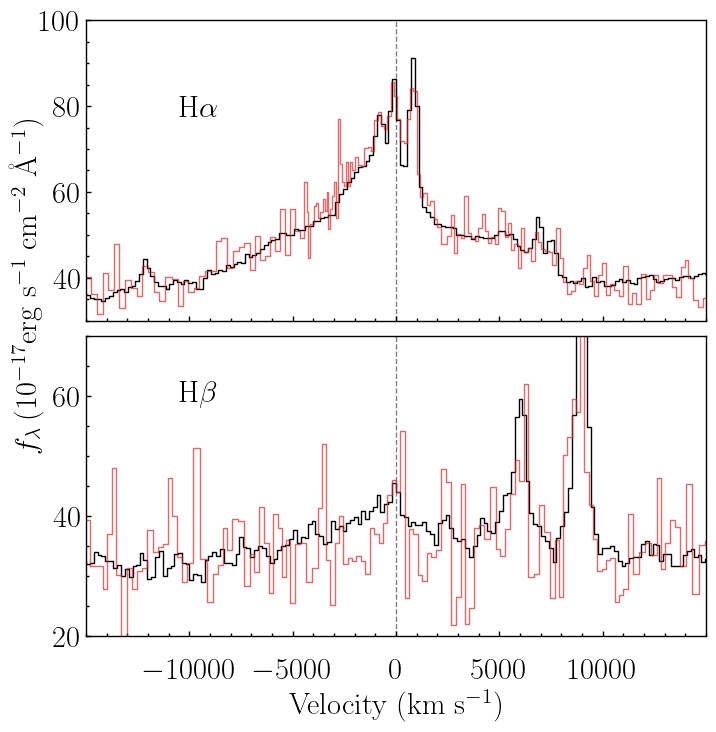

In [55]:
plt.rc('text', usetex=True)
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 22,
    'axes.linewidth': 2,  # Set default axis linewidth
    'xtick.major.width': 2,
    'ytick.major.width': 2,
    'xtick.minor.width': 2,
    'ytick.minor.width': 2
})

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 8), sharex=True)
plt.subplots_adjust(#left=0.2,
                    #bottom=0.09,
                    #right=0.8,
                    #top=0.98,
                    #wspace=0.2,
                    hspace=0.05)

# Define the common line width
line_width = 1.0

# Function to set the border width of the axes
def set_border_width(ax, width):
    for spine in ax.spines.values():
        spine.set_linewidth(width)

# Set up x-axis ticks
major_ticks = np.arange(-10000, 10001, 5000)
minor_ticks = np.arange(-10000, 10001, 1000)


# Plot Halpha
ax1.axvline(x=0, color='grey', linestyle='--', linewidth=line_width, zorder=1)

ax1.plot(vel_halpha, flux_halpha, color="black", drawstyle='steps-mid', linewidth=line_width, zorder=2)
ax1.plot(binned_velocity_halpha-260, binned_flux_halpha+22, color="#D62728", drawstyle='steps-mid', linewidth=line_width, zorder=2, alpha = 0.7)
ax1.set_xlim(-10000, 10000)
ax1.set_ylim(30, 100)
ax1.text(0.15, 0.75, r'H$\alpha$', transform=ax1.transAxes, verticalalignment='top')
set_border_width(ax1, line_width)
ax1.set_xticks(major_ticks)
ax1.set_xticks(minor_ticks, minor=True)

# Plot Hbeta
ax2.axvline(x=0, color='grey', linestyle='--', linewidth=line_width, zorder=1)

ax2.plot(vel_hbeta, flux_hbeta, color="black", drawstyle='steps-mid', linewidth=line_width, zorder=2)
ax2.plot(binned_velocity_hbeta-700, binned_flux_hbeta+13, color="#D62728", drawstyle='steps-mid', linewidth=line_width, zorder=2, alpha = 0.7)
ax2.set_xlim(-15000, 15000)
ax2.set_ylim(20, 70)
ax2.text(0.15, 0.85, r'H$\beta$', transform=ax2.transAxes, verticalalignment='top')
set_border_width(ax2, line_width)
ax2.set_xticks(major_ticks)
ax2.set_xticks(minor_ticks, minor=True)

# Common y-axis label
fig.text(0.03, 0.55, r'$f_{\lambda} \:(10^{-17} \mathrm{erg\ s^{-1}\ cm^{-2}\ \AA^{-1}})$', va='center', rotation='vertical')

# Add minor ticks and set tick parameters
for ax in [ax1, ax2]:
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', direction='in', width=line_width)
    ax.tick_params(axis='x', which='major', pad=15)
    ax.tick_params(axis='x', which='minor', pad=10)

ax2.set_xlabel("Velocity (km s$^{-1}$)")

#plt.tight_layout(rect=[0.05, 0, 1, 1])
plt.savefig("paper_figures/comparison_spectra.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
np.savez('spectra_data.npz', vel_halpha=vel_halpha, flux_halpha=flux_halpha, binned_velocity_halpha=binned_velocity_halpha, binned_flux_halpha=binned_flux_halpha, vel_hbeta=vel_hbeta, flux_hbeta=flux_hbeta, binned_velocity_hbeta=binned_velocity_hbeta, binned_flux_hbeta=binned_flux_hbeta)